<a href="https://colab.research.google.com/github/abolfazl328/GTZAN_dataset_classication/blob/main/GTZAN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This cell imports the necessary Python libraries. These libraries provide tools for audio processing, machine learning, data manipulation, and visualization, setting up the environment for the project.  Specifically:

*   **`kagglehub`:** For downloading the dataset.
*   **`os`:** For interacting with the file system.
*   **`librosa`:** For audio analysis and feature extraction.
*   **`numpy`:** For numerical operations and array manipulation.
*   **`tensorflow`:** For building and training the machine learning model.
*   **`sklearn`:** For data splitting and model evaluation.
*   **`audiomentations`:** For augmenting the audio data.
*   **`tensorflow.keras.callbacks`:** For model training control (early stopping, learning rate reduction).
*   **`matplotlib` and `seaborn`:** For data visualization.

These imports make the functions from these libraries available for use in the subsequent code cells.

In [1]:
import kagglehub
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split  # For data splitting
import audiomentations
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import imgaug.augmenters as iaa

This cell configures TensorFlow to use available GPUs for training. It checks for GPUs and enables memory growth to prevent out-of-memory errors during the training process.  This allows TensorFlow to dynamically allocate GPU memory as needed, which is crucial for handling large datasets and complex models.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True) # Prevents memo
      print("GPU is available and enabled for training.")
  except RuntimeError as e:
    print(e)

GPU is available and enabled for training.


This cell downloads the GTZAN music genre classification dataset from Kaggle Hub. It then prints the local path to the downloaded audio files.  The path will look something like this (but will depend on your operating system and Kaggle Hub configuration):

In [3]:
# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")+"/Data/genres_original"
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original


In [4]:
list_of_musics = os.listdir(path)
list_of_musics

['rock',
 'pop',
 'classical',
 'hiphop',
 'country',
 'jazz',
 'metal',
 'reggae',
 'disco',
 'blues']

This cell defines a function called `format_with_zeros`. This function takes a number as input and formats it as a string with leading zeros, ensuring a consistent five-digit format. For example, the number 12 would be formatted as "00012". This is likely used for consistent file naming or data organization.

In [5]:
def format_with_zeros(number):
  return "{:05d}".format(number)

This cell defines a function `loadaudio` to load audio files.  It uses `librosa.load` to load the audio and returns the audio data and its sample rate.  It includes error handling to catch and report issues if a file cannot be loaded.  The `sr=None` argument tells librosa not to resample the audio, preserving the original sample rate.

In [6]:
  def load_audio(audio_file):
    try:
      audio, sr = librosa.load(audio_file, sr=None) # Load with a maximum duration of 30 seconds
      return audio, sr
    except Exception as e:
      print(f"Error loading audio file {audio_file}: {e}")
      return None, None

# Data Augmentation Pipeline
This code defines a sequence of data augmentation transformations using the `imgaug` library. The sequence is composed of the following augmentations:

- **Horizontal Flip** (`iaa.Fliplr(0.5)`): Applies a horizontal flip with a probability of 50%.
- **Vertical Flip** (`iaa.Flipud(0.5)`): Applies a vertical flip with a probability of 50%.
- **Random Rotation** (`iaa.Affine(rotate=(-20, 20))`): Rotates the image randomly within the range of -20 to +20 degrees.
- **Random Scaling** (`iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)})`): Scales the image randomly along the x and y axes within the range of 0.8x to 1.2x.
- **Gaussian Blur** (`iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5)))`): Applies Gaussian blur with a sigma value between 0 and 0.5, with a 50% chance of application.

This augmentation pipeline introduces variability to the dataset, which helps improve the generalization capability of machine learning models.
```

In [7]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Flipud(0.5),  # Vertical flip
    iaa.Affine(rotate=(-20, 20)),  # Random rotation
    iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}), # Random scaling
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))), # Gaussian blur
])

# Spectrogram Augmentation Function
This function applies the defined data augmentation pipeline to a given spectrogram.

- **Input**: A spectrogram represented as a 2D array.
- **Process**:
  - Adds a batch dimension (`np.newaxis`) to the spectrogram, making it compatible with the `imgaug` library.
  - Adds a channel dimension (`np.newaxis`) since `imgaug` expects 4D inputs in the form `(batch_size, height, width, channels)`.
  - The `seq.augment_images` method is then applied to perform the augmentations defined earlier.
  - The output is reshaped to remove the added batch and channel dimensions, returning the augmented spectrogram.
- **Output**: The augmented spectrogram as a 2D array.

This function is used to introduce variability to the spectrogram data, enhancing the robustness of models trained on these features.


In [8]:
def augment_spectrogram(spectrogram):
    spectrogram_augmented = seq.augment_images(spectrogram[np.newaxis, :, :, np.newaxis])[0, :, :, 0] # Add batch and channel dimensions for imgaug
    return spectrogram_augmented

# Audio Data Loading and Labeling
This code snippet loads audio files from a structured dataset and creates a list of audio samples along with their corresponding labels.

- **Variables**:
  - `list_of_aduios`: Stores tuples of audio data and their sampling rates.
  - `list_of_audi_labels`: Stores the corresponding labels for each audio sample.

- **Process**:
  1. Iterates over `list_of_musics`, where each item represents a music category or class.
  2. For each category (`i`), loops through a range of 100 to locate audio files using the `path` and a formatted filename.
  3. Calls the `load_audio` function to load the audio file and its sampling rate (`sr`).
  4. Checks if the audio file was successfully loaded (i.e., `audio is not None`).
  5. Appends the loaded audio data and its sampling rate as a tuple to `list_of_aduios`.
  6. Appends the class label (`k`, representing the index of the music category) to `list_of_audi_labels`.

- **Output**:
  - A list of audio data and their corresponding labels, ready for preprocessing or model training.

This ensures the dataset is organized and labeled correctly for classification tasks.


In [9]:
list_of_aduios = []
list_of_audi_labels = []
for k, i in enumerate(list_of_musics):
  for j in range(100):
    audio_file = path+f"/{i}/{i}.{format_with_zeros(j)}.wav"
    audio, sr = load_audio(audio_file)
    if audio is None:
      continue
    list_of_aduios.append((audio,sr))
    list_of_audi_labels.append(k)

<ipython-input-6-956375929d88>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_file, sr=None) # Load with a maximum duration of 30 seconds
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading audio file /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original/jazz/jazz.00054.wav: 


# Splitting Data into Training and Testing Sets
This code splits the dataset of audio samples and their labels into training and testing sets.

- **Function Used**: `train_test_split` from `sklearn.model_selection`.

- **Inputs**:
  - `list_of_aduios`: The list of audio data (features).
  - `list_of_audi_labels`: The list of corresponding labels.
  - `test_size=0.2`: Specifies that 20% of the data will be used for testing, and the remaining 80% for training.
  - `random_state=42`: Ensures reproducibility of the split by using a fixed random seed.

- **Outputs**:
  - `x_train`: Training set features (audio data).
  - `x_test`: Testing set features (audio data).
  - `y_train`: Training set labels.
  - `y_test`: Testing set labels.

This step is crucial for evaluating the model's performance by training on one portion of the data and testing on an unseen portion.


In [10]:
x_train, x_test, y_train, y_test = train_test_split(list_of_aduios, list_of_audi_labels, test_size=0.2, random_state=42) # 80% train, 20% test

# Normalization Function for Log-Mel Spectrogram
This function normalizes a log-Mel spectrogram to ensure consistent scaling of the input features, which is beneficial for machine learning models.

- **Input**:
  - `log_mel_spectrogram`: The input log-Mel spectrogram array (2D or 3D, representing time and channels).

- **Process**:
  1. **Compute Mean**: Calculates the mean of the spectrogram values across time and channels using `np.mean(log_mel_spectrogram, axis=(0, 1), keepdims=True)`.
  2. **Compute Standard Deviation**: Computes the standard deviation across time and channels using `np.std(log_mel_spectrogram, axis=(0, 1), keepdims=True)`.
  3. **Normalization**: Subtracts the mean from the spectrogram values and divides by the standard deviation. A small `epsilon` (1e-7) is added to the denominator for numerical stability to prevent division by zero.
  4. **Return**: Outputs the normalized spectrogram.

- **Output**:
  - `normalized_spectrogram`: The normalized log-Mel spectrogram with zero mean and unit variance.

This normalization helps reduce variability in the input data caused by differences in amplitude, making it more suitable for training models.


In [11]:
def normalize_spectrogram(log_mfcc):
      mean = np.mean(log_mel_spectrogram, axis=(0, 1), keepdims=True)  # Mean across time and channels
      std = np.std(log_mel_spectrogram, axis=(0, 1), keepdims=True)
      epsilon = 1e-7
      normalized_spectrogram = (log_mel_spectrogram - mean) / (std + epsilon)
      return normalized_spectrogram

# Function: `plot_log_mel_spectrogram`

This function is designed to visualize log-mel spectrograms, a common representation of audio signals used in audio analysis and machine learning tasks. The visualization helps in understanding the spectral content of an audio signal over time.

---

## Parameters

### `log_mel_spectrogram`
- **Type**: `numpy.ndarray`  
- **Description**:  
  The log-mel spectrogram to visualize, typically generated using the `take_mel_spectrogram` function. It represents the time-frequency distribution of an audio signal, scaled logarithmically.

### `sr`
- **Type**: `int`  
- **Description**:  
  The sample rate of the audio signal. Used to appropriately label the time axis.

### `title` (optional)
- **Type**: `str`  
- **Default**: `"Log-Mel Spectrogram"`  
- **Description**:  
  Title of the plot for better context and identification.

---

## Functionality

1. **Spectrogram Rendering**  
   The function uses `librosa.display.specshow` to visualize the log-mel spectrogram. The x-axis represents time, while the y-axis represents mel frequency bins, providing a clear and intuitive view of the spectral content.

2. **Color Mapping**  
   A colormap (`magma`) is applied to represent the intensity (amplitude in decibels) of frequencies over time, offering a gradient-based view.

3. **Axis Labeling and Title**  
   - The x-axis shows time in seconds.
   - The y-axis displays mel frequency bins in Hz.
   - A customizable title provides additional context.

4. **Dynamic Range Visualization**  
   A colorbar is added to display the dynamic range of decibel values, offering an interpretation of the intensity scale.

5. **Layout Optimization**  
   `plt.tight_layout()` ensures all components of the plot are properly arranged without overlap.

6. **Display**  
   The plot is shown using `plt.show()`.

---

## Example Usage

```python
# Generate a log-mel spectrogram
log_mel_spectrogram = take_mel_spectrogram(audio, sr)

# Plot the spectrogram
plot_log_mel_spectrogram(log_mel_spectrogram, sr, title="Audio Spectrogram Example")


In [55]:
def plot_log_mel_spectrogram(log_mel_spectrogram, sr, title="Log-Mel Spectrogram"):
    """
    Plots a log-mel spectrogram using matplotlib and librosa.

    Args:
    - log_mel_spectrogram (numpy.ndarray): The log-mel spectrogram to visualize.
    - sr (int): Sample rate of the audio.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

# Function to Compute Log-Mel Spectrogram
This function generates a log-Mel spectrogram from an audio signal, a common feature representation used in audio processing and machine learning tasks.

- **Inputs**:
  - `audio`: The audio signal as a 1D array.
  - `sr`: The sampling rate of the audio signal.

- **Process**:
  1. **Compute Mel Spectrogram**:
     - Uses `librosa.feature.melspectrogram` to compute the Mel spectrogram of the input audio.
     - `n_mels=128`: Specifies the number of Mel bands. This can be adjusted based on the requirements.
  2. **Convert to Log Scale**:
     - Converts the Mel spectrogram to decibels (logarithmic scale) using `librosa.power_to_db`.
     - `ref=np.max`: Normalizes the values relative to the maximum power in the spectrogram.

- **Output**:
  - `log_mel_spectrogram`: The computed log-Mel spectrogram, which emphasizes perceptually relevant features of the audio.

This function transforms raw audio data into a feature-rich representation suitable for audio classification and other signal processing tasks.


In [12]:
def take_mel_spectogram(audio, sr):
      mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)  # Adjust n_mels as needed
      log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max) # Convert to decibels
      return log_mel_spectrogram

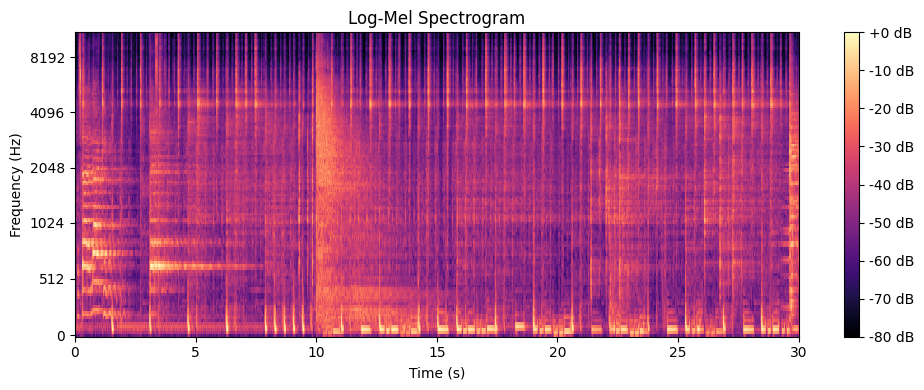

In [56]:
log_mel_spectrogram = take_mel_spectogram(x_train[0][0], x_train[0][1])  # Generate the log-mel spectrogram
plot_log_mel_spectrogram(log_mel_spectrogram, x_train[0][1])

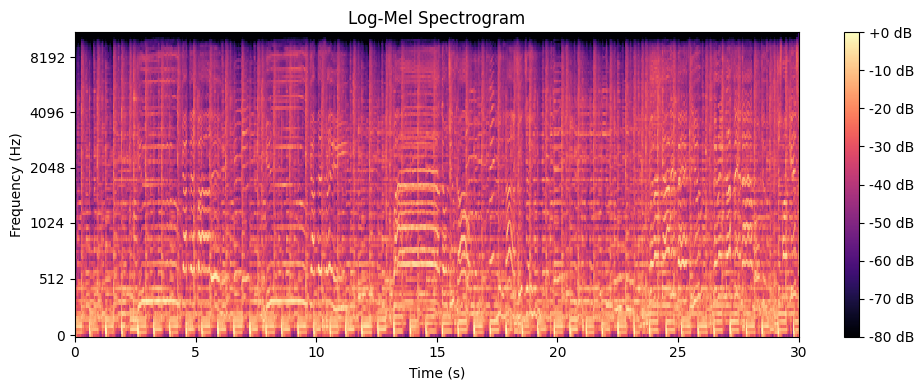

In [57]:
log_mel_spectrogram = take_mel_spectogram(x_test[0][0], x_test[0][1])  # Generate the log-mel spectrogram
plot_log_mel_spectrogram(log_mel_spectrogram, x_test[0][1])

# Data Augmentation and Feature Extraction
This code performs feature extraction and data augmentation for the training dataset.

- **Variables**:
  - `unnormalized_x`: A list to store log-Mel spectrograms (both original and augmented).
  - `unnormalized_y`: A list to store the corresponding labels.
  - `n_augmentations_per_clip`: Specifies the number of augmentations to generate for each audio clip.
  - `count`: A counter to keep track of processed audio clips.

- **Process**:
  1. Iterates through the training dataset (`x_train` and `y_train`), where `x_train` contains audio data (audio signal and sampling rate) and `y_train` contains labels.
  2. For each audio clip:
     - Computes the log-Mel spectrogram using the `take_mel_spectogram` function.
     - Appends the original log-Mel spectrogram to `unnormalized_x` and its label to `unnormalized_y`.
  3. Generates `n_augmentations_per_clip` augmented versions of the spectrogram:
     - Applies the `augment_spectrogram` function to the log-Mel spectrogram.
     - Appends each augmented spectrogram to `unnormalized_x` and its corresponding label to `unnormalized_y`.

- **Output**:
  - `unnormalized_x`: A list of original and augmented log-Mel spectrograms.
  - `unnormalized_y`: A list of labels corresponding to the spectrograms.

This process ensures that the dataset is enriched with augmented examples, increasing its size and diversity, which helps improve the generalization ability of the model.


In [13]:
unnormalized_x = []
unnormalized_y = []
n_augmentations_per_clip = 3
count = 0
for audio, label in zip(x_train, y_train):
  count+=1
  log_mel_spectrogram = take_mel_spectogram(audio[0], audio[1])
  unnormalized_x.append(log_mel_spectrogram)
  unnormalized_y.append(label)
  for i in range(n_augmentations_per_clip):
      log_mel_spectrogram_augmented = augment_spectrogram(log_mel_spectrogram)
      unnormalized_x.append(log_mel_spectrogram_augmented)
      unnormalized_y.append(label)

# Feature Extraction for Test Dataset
This code extracts features from the test dataset without applying data augmentation.

- **Variables**:
  - `unnormalized_x_test`: A list to store the log-Mel spectrograms for the test dataset.
  - `unnormalized_y_test`: A list to store the corresponding labels for the test dataset.
  - `count`: A counter to track the number of processed audio clips.

- **Process**:
  1. Iterates through the test dataset (`x_test` and `y_test`), where `x_test` contains audio data (audio signal and sampling rate) and `y_test` contains labels.
  2. For each audio clip:
     - Computes the log-Mel spectrogram using the `take_mel_spectogram` function.
     - Appends the computed log-Mel spectrogram to `unnormalized_x_test`.
     - Appends the corresponding label to `unnormalized_y_test`.

- **Output**:
  - `unnormalized_x_test`: A list of log-Mel spectrograms for the test dataset.
  - `unnormalized_y_test`: A list of labels corresponding to the test spectrograms.

Unlike the training dataset, no augmentations are performed here to preserve the integrity of the test set for accurate evaluation.


In [14]:
unnormalized_x_test = []
unnormalized_y_test = []
n_augmentations_per_clip = 3
count = 0
for audio, label in zip(x_test, y_test):
  count+=1
  log_mel_spectrogram = take_mel_spectogram(audio[0], audio[1])
  unnormalized_x_test.append(log_mel_spectrogram)
  unnormalized_y_test.append(label)

# Splitting Data into Training and Validation Sets
This code splits the augmented training dataset into separate training and validation sets.

- **Function Used**: `train_test_split` from `sklearn.model_selection`.

- **Inputs**:
  - `unnormalized_x`: The list of original and augmented log-Mel spectrograms (features).
  - `unnormalized_y`: The list of corresponding labels.
  - `test_size=0.25`: Specifies that 25% of the data will be used for validation, and the remaining 75% for training.
  - `random_state=42`: Ensures reproducibility of the split by using a fixed random seed.

- **Outputs**:
  - `unnormalized_x_train`: Training set features (log-Mel spectrograms).
  - `unnormalized_x_val`: Validation set features (log-Mel spectrograms).
  - `unnormalized_y_train`: Training set labels.
  - `unnormalized_y_val`: Validation set labels.

This step ensures that the model has a dedicated validation set to evaluate its performance during training, which helps in fine-tuning the model.


In [15]:
unnormalized_x_train, unnormalized_x_val, unnormalized_y_train, unnormalized_y_val = train_test_split(unnormalized_x, unnormalized_y, test_size=0.25, random_state=42) # split train+val to train and val

# One-Hot Encoding of Labels
This code converts the categorical labels into one-hot encoded format, which is a standard representation for classification tasks.

- **Function Used**: `tf.keras.utils.to_categorical`

- **Inputs**:
  - `unnormalized_y_train`: The training labels.
  - `unnormalized_y_test`: The test labels.
  - `unnormalized_y_val`: The validation labels.
  - `num_classes=10`: Specifies the number of possible classes (in this case, 10 classes).

- **Process**:
  1. The function `to_categorical` is used to convert the labels into a one-hot encoded format. Each label is transformed into a binary vector where the index corresponding to the correct class is set to 1, and all other indices are set to 0.
  
- **Outputs**:
  - `unnorm_y_train`: One-hot encoded labels for the training set.
  - `unnorm_y_test`: One-hot encoded labels for the test set.
  - `unnorm_y_val`: One-hot encoded labels for the validation set.

One-hot encoding is essential for multi-class classification models, as it allows the model to predict the probability of each class independently.


In [16]:
num_classes = 10
unnorm_y_train = tf.keras.utils.to_categorical(unnormalized_y_train, num_classes=num_classes)
unnorm_y_test = tf.keras.utils.to_categorical(unnormalized_y_test, num_classes=num_classes)
unnorm_y_val = tf.keras.utils.to_categorical(unnormalized_y_val, num_classes=num_classes)

# Data Generators for Training, Testing, and Validation
This code defines generators for feeding data into the model in batches during training, testing, and validation.

- **Generators**:
  - `generator_unnorm_train`: A generator function for the training dataset.
  - `generator_unnorm_test`: A generator function for the test dataset.
  - `generator_unnorm_validation`: A generator function for the validation dataset.

- **Process**:
  1. Each generator is a lambda function that:
     - Loops through the corresponding dataset (`unnormalized_x_train`, `unnormalized_x_test`, or `unnormalized_x_val`), and the corresponding labels (`unnorm_y_train`, `unnorm_y_test`, or `unnorm_y_val`).
     - For each sample (`x`), it expands the dimensions of the spectrogram (using `np.expand_dims(x, axis=-1)`) to add a channel dimension, as required by most deep learning frameworks.
     - Yields pairs of the formatted spectrogram (`x`) and the one-hot encoded label (`y_`) for use in model training or evaluation.

- **Outputs**:
  - These generators yield batches of data, where each batch is a tuple of `(spectrogram, label)`, suitable for input into a neural network.

Using generators is efficient for large datasets, as they allow data to be loaded and processed on the fly in batches, minimizing memory usage.


In [17]:
generator_unnorm_train = lambda: ((np.expand_dims(x, axis=-1), y_) for x, y_ in zip(unnormalized_x_train, unnorm_y_train))
generator_unnorm_test = lambda: ((np.expand_dims(x, axis=-1), y_) for x, y_ in zip(unnormalized_x_test, unnorm_y_test))
generator_unnorm_validation = lambda: ((np.expand_dims(x, axis=-1), y_) for x, y_ in zip(unnormalized_x_val, unnorm_y_val))

# Creating TensorFlow Datasets for Training, Testing, and Validation
This code creates `tf.data.Dataset` objects for efficient batch processing during model training, testing, and validation.

- **Steps**:
  1. **Generator Functions**:
     - The datasets are built using the generator functions (`generator_unnorm_train`, `generator_unnorm_test`, `generator_unnorm_validation`), which yield `(spectrogram, label)` pairs.
  
  2. **Dataset Creation**:
     - `tf.data.Dataset.from_generator`: This function converts the generator into a `tf.data.Dataset` object, which is more efficient for handling large datasets in TensorFlow.
     - The `output_signature` defines the shapes and types of the data:
       - The spectrogram (`x`) has a shape of `(128, None, 1)` where `128` is the number of Mel bands and `None` is the time dimension (which is padded).
       - The label (`y_`) is one-hot encoded with a shape of `(num_classes,)` where `num_classes` is the number of classes (10 in this case).
  
  3. **Padding and Batching**:
     - `padded_batch`: Ensures that all spectrograms in a batch have the same time dimension by padding the shorter spectrograms to match the longest one.
     - `batch_size=32`: Specifies the size of each batch.
     - `padded_shapes=([128, None, 1], [num_classes])`: Pads the time dimension of the spectrograms to `None` (dynamic) and leaves the label shape unchanged.
     - `padding_values=(0.0, 0.0)`: Specifies the padding value for both the spectrograms (0.0) and the labels (0.0).
     - `drop_remainder=False`: Ensures the last batch is kept even if it has fewer samples than the specified batch size.

- **Outputs**:
  - `unnorm_train_dataset`: The TensorFlow dataset for training, with padded spectrograms and labels, ready for model input.
  - `unnorm_test_dataset`: The TensorFlow dataset for testing, similarly padded and batched.
  - `unnorm_validation_dataset`: The TensorFlow dataset for validation, also padded and batched.

Using `tf.data.Dataset` optimizes the data pipeline by allowing efficient input and pre-processing during training and evaluation.


In [18]:
unnorm_train_dataset = tf.data.Dataset.from_generator(
    generator_unnorm_train,
    output_signature=(
        tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    ),
).padded_batch(
    batch_size=32,
    padded_shapes=([128, None, 1], [num_classes]),  # Pad time dimension to None
    padding_values=(0.0, 0.0), # Padding value for spectrograms and labels
    drop_remainder=False # Keep last batch even if it is not full
)

unnorm_test_dataset = tf.data.Dataset.from_generator(
    generator_unnorm_test,
    output_signature=(
        tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    ),
).padded_batch(
    batch_size=32,
    padded_shapes=([128, None, 1], [num_classes]),  # Pad time dimension to None
    padding_values=(0.0, 0.0), # Padding value for spectrograms and labels
    drop_remainder=False # Keep last batch even if it is not full
)

unnorm_validation_dataset = tf.data.Dataset.from_generator(
    generator_unnorm_validation,
    output_signature=(
        tf.TensorSpec(shape=(128, None, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    )
).padded_batch(
    batch_size=32,  # Or another appropriate batch size
    padded_shapes=([128, None, 1], [num_classes]),
    padding_values=(0.0, 0.0),
    drop_remainder=False
)

In [19]:
print(unnorm_train_dataset)
print(unnorm_test_dataset)
print(unnorm_validation_dataset)

<_PaddedBatchDataset element_spec=(TensorSpec(shape=(None, 128, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_PaddedBatchDataset element_spec=(TensorSpec(shape=(None, 128, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
<_PaddedBatchDataset element_spec=(TensorSpec(shape=(None, 128, None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>


# Model Architecture for Audio Classification
This code defines a convolutional neural network (CNN) model for audio classification, using log-Mel spectrograms as input features.

- **Model Overview**:
  The model is a `tf.keras.models.Sequential` that consists of several convolutional layers, batch normalization, max pooling, and dense layers. Dropout is used for regularization.

- **Layers**:
  1. **Conv2D Layers**:
     - Each `Conv2D` layer applies 32, 64, 128, and 256 filters with a kernel size of `(3, 3)` to extract spatial features from the spectrograms.
     - The `relu` activation function is used for non-linearity.
     - `kernel_regularizer=tf.keras.regularizers.l2(0.01)` applies L2 regularization to reduce overfitting by penalizing large weights.
  
  2. **Batch Normalization**:
     - Each convolutional block is followed by `BatchNormalization`, which normalizes the activations of the previous layer to accelerate training and improve generalization.
  
  3. **MaxPooling2D Layers**:
     - `MaxPooling2D` with a pool size of `(2, 2)` reduces the spatial dimensions of the feature maps by downsampling, which helps to capture hierarchical features and reduce computational load.
  
  4. **GlobalAveragePooling2D**:
     - This layer reduces each feature map to a single value by averaging over the entire spatial dimension, resulting in a vector of size equal to the number of filters in the last convolutional layer (256 in this case).
  
  5. **Dense Layers**:
     - A dense layer with 256 units and ReLU activation follows, allowing the network to learn high-level representations.
     - A `Dropout(0.5)` layer is applied after the dense layer to reduce overfitting by randomly setting half of the input units to zero during training.
  
  6. **Output Layer**:
     - The final `Dense` layer has `num_classes` units (10 in this case), with a `softmax` activation to output a probability distribution over the classes.

- **Compilation**:
  - The model is compiled with:
    - **Optimizer**: Adam optimizer (`'adam'`), a popular choice for training deep learning models.
    - **Loss Function**: `categorical_crossentropy`, which is suitable for multi-class classification problems with one-hot encoded labels.
    - **Metrics**: Accuracy (`'accuracy'`) to evaluate the model’s performance during training.

This CNN model is designed for classification tasks, where the input is a log-Mel spectrogram and the output is a probability distribution over the classes.


In [34]:
unnorm_dataset_model= tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), input_shape=(128, None, 1)),
    tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # More Conv layers
    tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Even more Conv layers
    # tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    # tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),

    # tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Larger Dense Layer
    # tf.keras.layers.Dropout(0.5),  # Dropout for regularization

    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Another Dense Layer
    tf.keras.layers.Dropout(0.5),  # Dropout for regularization

    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer
])

unnorm_dataset_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Learned Normalization Layer
This code defines a custom TensorFlow layer for learned normalization, which can be used to normalize inputs dynamically during training. The layer learns its own parameters for normalization (mean and standard deviation), similar to batch normalization but with trainable parameters.

- **Class Overview**:
  - `LearnedNormalizationLayer` inherits from `tf.keras.layers.Layer`, allowing it to be used as a custom layer in any Keras model.

- **Methods**:
  1. **`__init__(self, **kwargs)`**:
     - The constructor calls the parent class constructor (`super`) to initialize the layer. It doesn't require any special arguments here.

  2. **`build(self, input_shape)`**:
     - This method defines the trainable parameters for the layer:
       - `self.mean`: A trainable weight initialized to zeros, with shape `(1, 1, 1, input_shape[-1])`. The last dimension corresponds to the number of channels in the input.
       - `self.std`: A trainable weight initialized to ones, with the same shape as `self.mean`.
       - `self.epsilon`: A small constant (1e-7) to avoid division by zero.
     - The `super(LearnedNormalizationLayer, self).build(input_shape)` ensures that any additional setup from the parent class is also performed.

  3. **`call(self, inputs)`**:
     - This method defines how the inputs are processed when passed through the layer:
       - The input is normalized by subtracting the learned mean (`self.mean`) and dividing by the absolute value of the learned standard deviation (`self.std`), with a small epsilon added for numerical stability.
       - `tf.abs(self.std)` ensures that the standard deviation is always positive, avoiding division by negative values.

- **Purpose**:
  This custom normalization layer can be used to learn and apply normalization parameters (mean and std) to input data, which can be useful in certain models that require more flexibility than traditional normalization techniques such as batch normalization.


In [35]:
class LearnedNormalizationLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LearnedNormalizationLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mean = self.add_weight(name="mean", shape=(1, 1, 1, input_shape[-1]),  # Shape for broadcasting
                                initializer=tf.keras.initializers.Zeros(), trainable=True)
        self.std = self.add_weight(name="std", shape=(1, 1, 1, input_shape[-1]),
                               initializer=tf.keras.initializers.Ones(), trainable=True)
        self.epsilon = 1e-7
        super(LearnedNormalizationLayer, self).build(input_shape)

    def call(self, inputs):
        return (inputs - self.mean) / (tf.abs(self.std) + self.epsilon)  # Use tf.abs to ensure std is positive


# Model Architecture with Learned Normalization
This code defines a convolutional neural network (CNN) model for audio classification, incorporating the custom `LearnedNormalizationLayer` to perform learned normalization on the input spectrograms.

- **Model Overview**:
  The model is a `tf.keras.models.Sequential` and follows a typical CNN architecture with layers of convolutions, batch normalization, pooling, and dense layers. The key difference is the use of the custom `LearnedNormalizationLayer` to normalize the inputs before passing them through the convolutional layers.

- **Layers**:
  1. **LearnedNormalizationLayer**:
     - The first layer of the model is the custom `LearnedNormalizationLayer` applied to the input. It learns the normalization parameters (mean and standard deviation) for each input sample dynamically during training.
     - This allows the model to apply a more flexible normalization strategy than traditional batch normalization.
  
  2. **Conv2D Layers**:
     - These convolutional layers apply 32, 64, 128, and 256 filters with kernel size `(3, 3)` to learn spatial features from the log-Mel spectrograms.
     - Each convolutional layer uses the `relu` activation function to introduce non-linearity and is followed by `BatchNormalization` to stabilize training.
  
  3. **MaxPooling2D Layers**:
     - Each `MaxPooling2D` layer with a pool size of `(2, 2)` down-samples the feature maps, reducing spatial dimensions and allowing the model to capture hierarchical patterns.
  
  4. **GlobalAveragePooling2D**:
     - This layer averages all the values in each feature map (across the spatial dimensions), resulting in a fixed-size output for each sample, which is useful for feeding into dense layers.
  
  5. **Dense Layers**:
     - A dense layer with 256 units and ReLU activation is added, followed by a `Dropout(0.5)` layer for regularization (randomly setting half of the units to zero during training).
  
  6. **Output Layer**:
     - The final `Dense` layer has `num_classes` units (10 in this case) and uses a `softmax` activation function to output a probability distribution over the 10 possible classes.

- **Compilation**:
  - The model is compiled with the following configurations:
    - **Optimizer**: Adam (`'adam'`), an efficient optimization algorithm widely used for training deep networks.
    - **Loss Function**: `categorical_crossentropy`, appropriate for multi-class classification problems with one-hot encoded labels.
    - **Metrics**: Accuracy (`'accuracy'`) to measure the performance of the model during training.

This CNN model incorporates learned normalization in the input layer to potentially enhance the model's ability to generalize and improve performance in complex audio classification tasks.


In [36]:
norm_dataset_model= tf.keras.models.Sequential([
    LearnedNormalizationLayer(input_shape=(128, None, 1)),  # Input shape added
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # More Conv layers
    tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    tf.keras.layers.MaxPooling2D((2, 2)),

    # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Even more Conv layers
    # tf.keras.layers.BatchNormalization(),  # Add Batch Normalization
    # tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),

    # tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Larger Dense Layer
    # tf.keras.layers.Dropout(0.5),  # Dropout for regularization

    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Another Dense Layer
    tf.keras.layers.Dropout(0.5),  # Dropout for regularization

    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer
])

norm_dataset_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

<ipython-input-35-d38cbed50f53>:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(LearnedNormalizationLayer, self).__init__(**kwargs)


# Early Stopping Callback
This code sets up an `EarlyStopping` callback for training the model, which helps prevent overfitting by stopping the training process if the validation loss doesn't improve after a specified number of epochs.

- **Parameters**:
  1. **`monitor='val_loss'`**:
     - The model will monitor the validation loss (`val_loss`) during training. If this loss stops improving, training will be halted early.
  
  2. **`patience=5`**:
     - The `patience` parameter specifies how many epochs with no improvement in validation loss should elapse before stopping the training. In this case, if the validation loss doesn't improve for 5 consecutive epochs, training will stop.
  
  3. **`restore_best_weights=True`**:
     - This ensures that the model restores the weights from the epoch where the validation loss was the lowest. This helps to ensure that the final model is the one with the best generalization, as it might have overfitted after some number of epochs.

- **Purpose**:
  Early stopping is an important regularization technique to prevent the model from overfitting to the training data. By halting training once the validation loss stops improving, it allows the model to stop learning noise and focus on generalizable features.


In [37]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the weights from the epoch with the best validation loss
)

# Reduce Learning Rate on Plateau Callback
This code sets up a `ReduceLROnPlateau` callback for the model's training process. It dynamically reduces the learning rate when the validation loss stops improving, which helps in fine-tuning the model and potentially improving convergence during training.

- **Parameters**:
  1. **`monitor='val_loss'`**:
     - The callback monitors the validation loss (`val_loss`). If the validation loss stops improving, it triggers the learning rate reduction.
  
  2. **`factor=0.5`**:
     - This parameter defines the factor by which the learning rate will be reduced. For instance, if the learning rate is `0.01`, it will be reduced to `0.005` (i.e., halved).
  
  3. **`patience=3`**:
     - The `patience` parameter specifies how many epochs with no improvement in validation loss will elapse before the learning rate is reduced. In this case, if the validation loss doesn't improve for 3 epochs, the learning rate will be halved.
  
  4. **`min_lr=1e-5`**:
     - The `min_lr` parameter sets the minimum possible learning rate. The learning rate will not decrease below this value, preventing the optimizer from becoming too slow.

- **Purpose**:
  The `ReduceLROnPlateau` callback is used to adjust the learning rate during training. When the model's validation loss plateaus (i.e., no longer improves), reducing the learning rate can help the model converge more smoothly and efficiently. This technique can also help to escape from local minima or saddle points in the loss landscape, potentially leading to better generalization and performance.


In [38]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by this factor (e.g., 0.5)
    patience=3,         # Number of epochs with no improvement before reducing LR
    min_lr=1e-5         # Minimum learning rate
)

# Model Training with Callbacks
This code trains the `unnorm_dataset_model` using the `fit` method, which trains the model on the training dataset and evaluates it on the validation dataset. Two callbacks, `early_stopping` and `reduce_lr`, are added to control the training process and improve the model's generalization.

- **Parameters**:
  1. **`unnorm_train_dataset`**:
     - The training dataset, which is a `tf.data.Dataset` object. It is used to feed the model with batches of data during training.
  
  2. **`epochs=50`**:
     - The number of epochs to train the model. An epoch refers to one complete pass through the entire training dataset. Here, the model will train for 50 epochs or until early stopping is triggered.

  3. **`validation_data=unnorm_validation_dataset`**:
     - The validation dataset used to evaluate the model after each epoch. This dataset helps in monitoring the model's performance on data it hasn't seen before, and it is used for early stopping and learning rate reduction.

  4. **`callbacks=[early_stopping, reduce_lr]`**:
     - The `early_stopping` callback halts training if the validation loss doesn't improve for 5 consecutive epochs, while the `reduce_lr` callback reduces the learning rate by a factor of 0.5 if the validation loss doesn't improve for 3 epochs.
  
- **Purpose**:
  - This code will train the model while using the callbacks to:
    1. Stop training early if no improvement in validation loss is detected (early stopping).
    2. Adjust the learning rate to potentially enhance training by reducing it when the validation loss plateaus (learning rate reduction).
  - These strategies help improve the model's performance and prevent overfitting.


In [39]:
unnormalized_data_train_history = unnorm_dataset_model.fit(
    unnorm_train_dataset,
    epochs=50,
    validation_data=unnorm_validation_dataset,
    callbacks=[early_stopping, reduce_lr]  # Add the callback here
    )  # Adjust epochs and batch size as needed

Epoch 1/50
     75/Unknown 58s 702ms/step - accuracy: 0.1942 - loss: 4.8178

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 67s 819ms/step - accuracy: 0.1949 - loss: 4.8115 - val_accuracy: 0.1627 - val_loss: 4.1034 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.3600 - loss: 3.2600 - val_accuracy: 0.2290 - val_loss: 3.0497 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.3781 - loss: 2.5948 - val_accuracy: 0.1877 - val_loss: 2.9704 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.4350 - loss: 2.2196 - val_accuracy: 0.2678 - val_loss: 2.4807 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.4430 - loss: 2.0093 - val_accuracy: 0.3667 - val_loss: 2.0916 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.4669 - loss: 1.8722 - val_accuracy: 0.2741 - val_loss: 2.3154 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.4784 - loss: 1.7774 - val_

# Function to Calculate Evaluation Metrics
This function calculates various evaluation metrics for a given model (either normalized or unnormalized) on the test dataset. The metrics calculated include accuracy, loss, F1-score, precision, recall, and the confusion matrix.

### Parameters:
- **`norm`**:
  - A boolean parameter that determines whether to use the model with normalized data (`True`) or the model with unnormalized data (`False`).

### Inside the function:
1. **Predictions and True Labels**:
   - The function iterates over the `unnorm_test_dataset` (or normalized dataset if `norm=True`).
   - For each batch in the dataset:
     - The model predicts the probabilities for each class.
     - The true labels are added to the list of true labels (`y_true`).
     - The predicted probabilities are added to the list of predicted probabilities (`y_pred_probs`).

2. **Loss Calculation**:
   - After making predictions for the entire test dataset, the loss is calculated using the model's `evaluate` function.

3. **Metric Calculations**:
   - **`y_pred`**: The predicted class labels, derived by taking the argmax of the predicted probabilities.
   - **`y_true`**: The true class labels, derived by taking the argmax of the true one-hot encoded labels.
   - **`f1_score`**: The macro-average F1 score, which balances precision and recall.
   - **`precision_score`**: The macro-average precision, measuring how many selected items are relevant.
   - **`recall_score`**: The macro-average recall, measuring how many relevant items are selected.
   - **`confusion_matrix`**: A confusion matrix showing the distribution of predicted vs actual classes.
   - **`accuracy`**: The model's accuracy, calculated by comparing the predicted labels to the true labels.

### Outputs:
- The function yields several metrics:
  1. **`y_pred`**: Predicted class labels.
  2. **`y_true`**: True class labels.
  3. **`accuracy`**: Accuracy of the model on the test dataset.
  4. **`loss`**: Loss value computed during evaluation.
  5. **`f1`**: F1-score of the model.
  6. **`precision`**: Precision of the model.
  7. **`recall`**: Recall of the model.
  8. **`cm`**: Confusion matrix showing the performance of the model.

### Purpose:
This function provides a comprehensive evaluation of the model's performance, including not only the traditional accuracy and loss but also more detailed metrics like precision, recall, and the F1-score, which are crucial for imbalanced classification problems. The confusion matrix is also useful for visualizing where the model is making mistakes.


In [40]:
def caluclate_measures(norm):
  y_pred_probs = []
  y_true = []
  if not norm:
    for x, y in unnorm_test_dataset:  # Iterate over the TensorFlow Dataset
      y_pred_batch_probs = unnorm_dataset_model.predict(x)  # Predict probabilities for the current batch
      y_pred_probs.extend(y_pred_batch_probs)  # Append the batch predictions
      y_true.extend(y.numpy())  # Append the true labels
    loss = unnorm_dataset_model.evaluate(unnorm_test_dataset, verbose=0)[0] # Loss from evaluate function
  else:
    for x, y in unnorm_test_dataset:  # Iterate over the TensorFlow Dataset
      y_pred_batch_probs = norm_dataset_model.predict(x)  # Predict probabilities for the current batch
      y_pred_probs.extend(y_pred_batch_probs)  # Append the batch predictions
      y_true.extend(y.numpy())  # Append the true labels
    loss = unnorm_dataset_model.evaluate(unnorm_test_dataset, verbose=0)[0] # Loss from evaluate function
  y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted labels
  y_true = np.argmax(y_true, axis=1)  # True labels (convert one-hot to class labels)
  f1 = f1_score(y_true, y_pred, average='macro')
  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  cm = confusion_matrix(y_true, y_pred)
  accuracy = tf.keras.metrics.Accuracy()(y_true, y_pred).numpy()
  yield y_pred
  yield y_true
  yield accuracy
  yield loss
  yield f1
  yield precision
  yield recall
  yield cm

# Evaluating Model on Test Data
This code runs the `caluclate_measures` function on the unnormalized test dataset and processes the results. It then extracts the class labels associated with the predicted classes.

### Steps:
1. **Calling the `caluclate_measures` function**:
   - The function is called with `norm=0`, indicating that the unnormalized model (`unnorm_dataset_model`) is being used.
   - The function returns multiple evaluation metrics, including:
     - **`unnorm_data_test_y_pred`**: The predicted labels for the test dataset.
     - **`unnorm_data_test_y_true`**: The true labels for the test dataset.
     - **`unnorm_data_test_accuracy`**: The accuracy score on the test dataset.
     - **`unnorm_data_test_loss`**: The loss value on the test dataset.
     - **`unnorm_data_test_f1`**: The F1-score on the test dataset.
     - **`unnorm_data_test_precision`**: The precision score on the test dataset.
     - **`unnorm_data_test_recall`**: The recall score on the test dataset.
     - **`unnorm_data_test_cm`**: The confusion matrix showing the model's performance on the test dataset.

2. **Extracting Class Labels**:
   - **`class_labels = np.unique(unnorm_data_test_y_pred)`**:
     - This line extracts the unique class labels from the predictions (`unnorm_data_test_y_pred`).
   - **`class_labels = [list_of_musics[i] for i in class_labels]`**:
     - This converts the class indices into actual class names by mapping them to the `list_of_musics` (which contains the names of the music genres or classes).
   
### Purpose:
This section of code calculates evaluation metrics for the unnormalized test dataset and provides the corresponding class labels associated with the predicted results. It helps assess how well the model is performing across different classes and enables the interpretation of evaluation metrics such as precision, recall, and the confusion matrix in the context of the actual class names.


In [41]:
unnorm_data_test_y_pred, unnorm_data_test_y_true, unnorm_data_test_accuracy, unnorm_data_test_loss, unnorm_data_test_f1, unnorm_data_test_precision, unnorm_data_test_recall, unnorm_data_test_cm = caluclate_measures(0)
class_labels = np.unique(unnorm_data_test_y_pred)
class_labels = [list_of_musics[i] for i in np.unique(unnorm_data_test_y_pred)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


In [42]:
print(f"Test Loss: {unnorm_data_test_loss}")
print(f"Test Accuracy: {unnorm_data_test_accuracy}")
print(f"F1-score: {unnorm_data_test_f1}")
print(f"Precision: {unnorm_data_test_precision}")
print(f"Recall: {unnorm_data_test_recall}")
print("Confusion Matrix:")
print(unnorm_data_test_cm)

Test Loss: 1.8229701519012451
Test Accuracy: 0.38999998569488525
F1-score: 0.37230179901827914
Precision: 0.5398479915668457
Recall: 0.401041239462292
Confusion Matrix:
[[ 4  1  7  0  8  0  1  0  0  0]
 [ 0  9  1  0  1  0  0  0  1  0]
 [ 0  0 24  0  0  0  0  0  0  0]
 [ 0 14  1  3  0  0  0  1  1  2]
 [ 1  0 11  0  2  1  0  0  0  0]
 [ 1  0 20  0  0  6  0  0  0  0]
 [ 4  0  0  0  0  0 14  0  0  0]
 [ 0  4  2  0  4  1  0  7  0  1]
 [ 1  9  2  0  3  0  0  1  4  2]
 [ 0  0 11  0  1  2  0  0  1  5]]


This cell visualizes the confusion matrix for the unnormalized test data. It uses `seaborn`'s `heatmap` function to create a visually appealing representation of the confusion matrix.  The `annot=True` argument displays the counts within each cell, `fmt='d'` formats the counts as integers, and `cmap='Blues'` sets the color scheme.  The x and y axis labels are set to the unique genre labels, and a title is added for clarity.  `plt.show()` displays the generated plot.

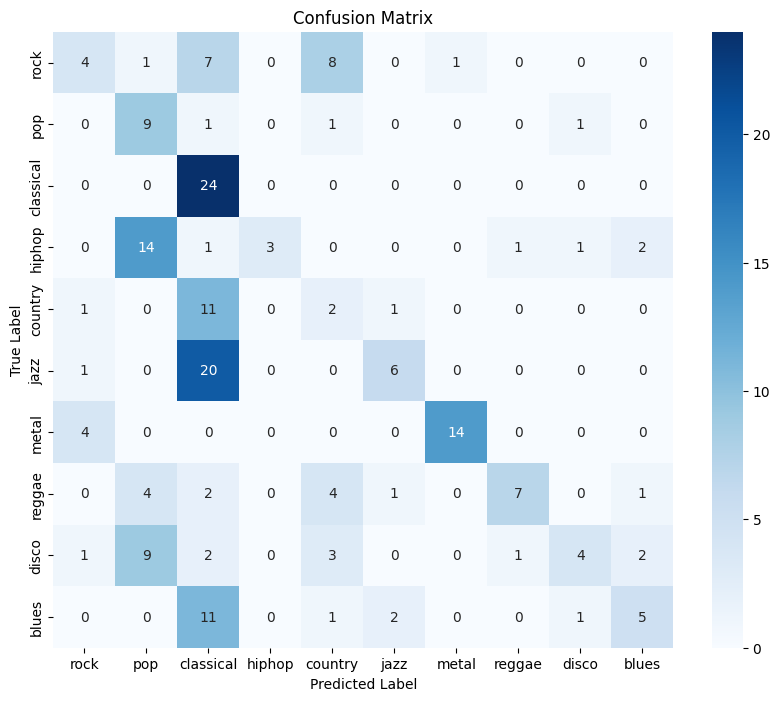

In [43]:
plt.figure(figsize=(10, 8))
sns.heatmap(unnorm_data_test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,  # Label columns with true labels
            yticklabels=class_labels)  # Label rows with true labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Training the Model on Normalized Data
This code trains the model with normalized input data using the `norm_dataset_model`. It fits the model on the unnormalized training dataset (`unnorm_train_dataset`) but uses the normalized architecture.

### Steps:
1. **Model Training**:
   - **`norm_dataset_model.fit()`** is called to train the model on the training data.
   - The model is trained for a specified number of epochs (50 in this case).
   - **`unnorm_train_dataset`** is the dataset used for training, which contains the unnormalized training samples.
   - **`unnorm_validation_dataset`** is used for validation to monitor the model's performance during training.

2. **Callbacks**:
   - **`early_stopping`**: Stops the training if the validation loss doesn't improve after a certain number of epochs (5 in this case), restoring the best weights from the epoch with the lowest validation loss.
   - **`reduce_lr`**: Reduces the learning rate if the validation loss stops improving, with a factor of 0.5, and a patience of 3 epochs.

### Purpose:
The goal of this code is to train the model on the normalized dataset while ensuring that the training process is stable and prevents overfitting by using early stopping and learning rate reduction techniques. The validation data helps monitor the model's generalization ability during training.


In [44]:
normalized_data_train_history = norm_dataset_model.fit(
    unnorm_train_dataset,
    epochs=50,
    validation_data=unnorm_validation_dataset,
    callbacks=[early_stopping, reduce_lr]  # Add the callback here
    )  # Adjust epochs and batch size as needed

Epoch 1/50
     75/Unknown 94s 671ms/step - accuracy: 0.2051 - loss: 4.8050

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 103s 792ms/step - accuracy: 0.2055 - loss: 4.7991 - val_accuracy: 0.2165 - val_loss: 4.0111 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.3296 - loss: 3.2658 - val_accuracy: 0.2215 - val_loss: 3.1330 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - accuracy: 0.3648 - loss: 2.5811 - val_accuracy: 0.2353 - val_loss: 2.7338 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.4087 - loss: 2.2313 - val_accuracy: 0.2979 - val_loss: 2.4450 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.4426 - loss: 2.0086 - val_accuracy: 0.2578 - val_loss: 2.3984 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.4532 - loss: 1.8643 - val_accuracy: 0.3479 - val_loss: 2.0696 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.4661 - loss: 1.7872 - val

# Evaluating Model on Normalized Test Data
This code evaluates the performance of the normalized model (`norm_dataset_model`) on the test dataset and processes the results. It also maps the predicted class labels to their corresponding names.

### Steps:
1. **Calling the `caluclate_measures` function**:
   - The function is called with `norm=1`, indicating that the normalized model (`norm_dataset_model`) is being used.
   - The function returns several evaluation metrics, including:
     - **`norm_data_test_y_pred`**: The predicted labels for the normalized test dataset.
     - **`norm_data_test_y_true`**: The true labels for the normalized test dataset.
     - **`norm_data_test_accuracy`**: The accuracy score on the normalized test dataset.
     - **`norm_data_test_loss`**: The loss value on the normalized test dataset.
     - **`norm_data_test_f1`**: The F1-score on the normalized test dataset.
     - **`norm_data_test_precision`**: The precision score on the normalized test dataset.
     - **`norm_data_test_recall`**: The recall score on the normalized test dataset.
     - **`norm_data_test_cm`**: The confusion matrix for the normalized test dataset.

2. **Extracting Class Labels**:
   - **`class_labels = np.unique(norm_data_test_y_pred)`**:
     - This line extracts the unique class labels from the predictions (`norm_data_test_y_pred`).
   - **`class_labels = [list_of_musics[i] for i in class_labels]`**:
     - This converts the class indices into actual class names by mapping them to the `list_of_musics` (which contains the names of the music genres or classes).

### Purpose:
This part of the code evaluates the performance of the normalized model on the test data. It generates important metrics like accuracy, F1-score, precision, and recall, and also provides a confusion matrix to better understand the model's classification behavior. The predicted class labels are then mapped to their respective names for easier interpretation.


In [45]:
norm_data_test_y_pred, norm_data_test_y_true, norm_data_test_accuracy, norm_data_test_loss, norm_data_test_f1, norm_data_test_precision, norm_data_test_recall, norm_data_test_cm = caluclate_measures(1)
class_labels = np.unique(unnorm_data_test_y_pred)
class_labels = [list_of_musics[i] for i in np.unique(norm_data_test_y_pred)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


In [46]:
print(f"Test Loss: {norm_data_test_loss}")
print(f"Test Accuracy: {norm_data_test_accuracy}")
print(f"F1-score: {norm_data_test_f1}")
print(f"Precision: {norm_data_test_precision}")
print(f"Recall: {norm_data_test_recall}")
print("Confusion Matrix:")
print(norm_data_test_cm)

Test Loss: 1.8229701519012451
Test Accuracy: 0.7049999833106995
F1-score: 0.6802190607780088
Precision: 0.7063011063011062
Recall: 0.695597769676717
Confusion Matrix:
[[ 4  0  0  0  9  0  1  2  4  1]
 [ 0  8  0  0  2  0  0  0  2  0]
 [ 0  0 19  0  0  5  0  0  0  0]
 [ 0  4  0 14  0  0  0  3  1  0]
 [ 1  0  0  0 10  2  0  0  0  2]
 [ 0  0  0  0  0 26  0  0  0  1]
 [ 2  0  0  1  0  0 14  0  0  1]
 [ 0  3  0  1  0  0  0 12  1  2]
 [ 0  1  0  0  4  0  0  1 15  1]
 [ 0  0  0  0  0  0  0  0  1 19]]


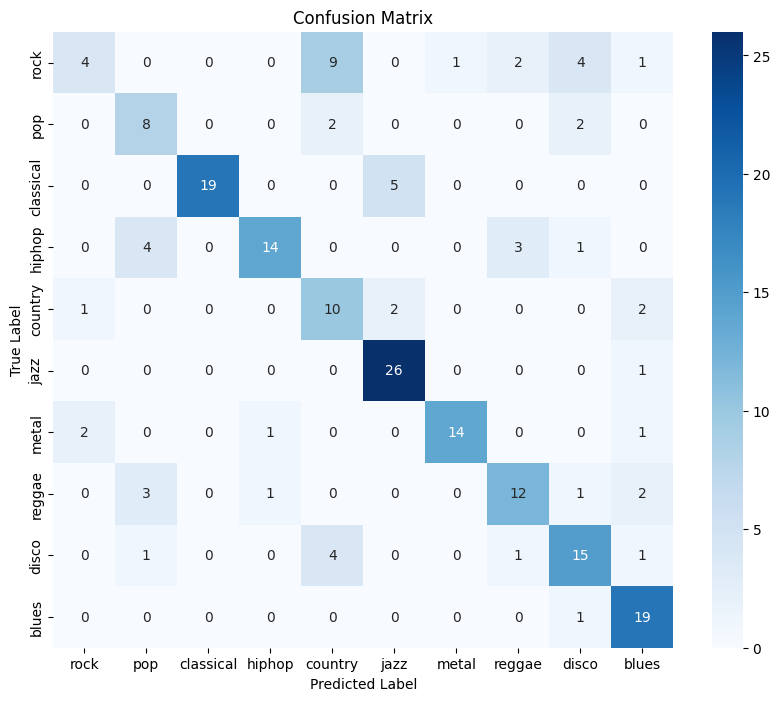

In [47]:
plt.figure(figsize=(10, 8))
sns.heatmap(norm_data_test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,  # Label columns with true labels
            yticklabels=class_labels)  # Label rows with true labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()